In [1]:
import glob
from collections import defaultdict
import random


import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2 as cv
import imagesize
import torchvision.transforms as T
from PIL import Image
from joblib import Parallel, delayed
from cuml.manifold import TSNE


In [2]:
all_train_files =  glob.glob("../student_db/train/**/*.png",recursive=True)
print("Number of all train files: ", len(all_train_files))

all_test_files =  glob.glob("../student_db/test/**/*.png",recursive=True)
print("Number of all test files: ", len(all_test_files))
print("all files: ", len(all_test_files) + len(all_train_files))

Number of all train files:  74333
Number of all test files:  4413
all files:  78746


In [3]:
train_subset_counts = defaultdict(int)
for train_file in all_train_files:
    f1 = train_file.replace("../student_db/train/", "")
    subset, img_name = f1.split("/")
    train_subset_counts[subset] += 1


In [4]:
test_subset_counts = defaultdict(int)
for train_file in all_test_files:
    f2 = train_file.replace("../student_db/test/", "")
    subset1, img_name = f2.split("/")
    test_subset_counts[subset1] += 1

test_subset_counts["doubt"] = 0
test_subset_counts

defaultdict(int, {'notrash': 2870, 'trash': 1543, 'doubt': 0})

{'trash': (10048, 1543), 'notrash': (39937, 2870), 'doubt': (24348, 0)}


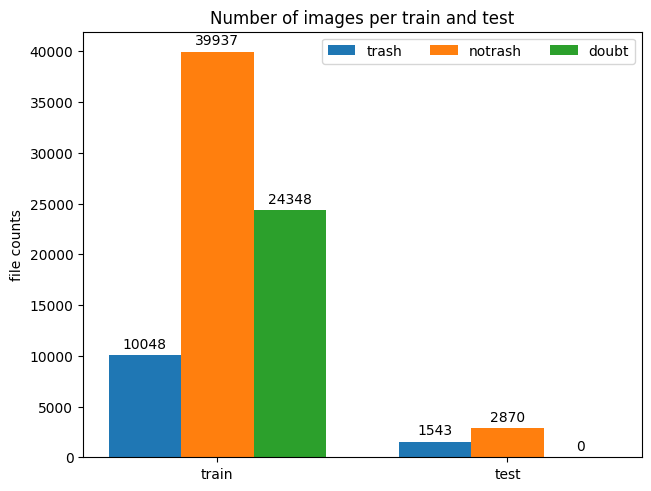

In [25]:
files_count = {
    "trash":(train_subset_counts["trash"], test_subset_counts["trash"]),
    "notrash":(train_subset_counts["notrash"], test_subset_counts["notrash"]),
    "doubt":(train_subset_counts["doubt"], test_subset_counts["doubt"]),
}
print(files_count)

x = np.arange(2)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for subset, count in files_count.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=subset)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('file counts')
ax.set_title('Number of images per train and test')
ax.set_xticks(x + width, ["train", "test"])
ax.legend(loc='upper right', ncols=3)
# ax.set_ylim(0, 250)

plt.show()


#### Show sizes

In [6]:
img_sizes = defaultdict(int)
for img_addr in all_train_files:
    (width, height) = imagesize.get(img_addr)
    img_sizes[(width, height)] += 1


/tmp/ipykernel_16922/2367035372.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


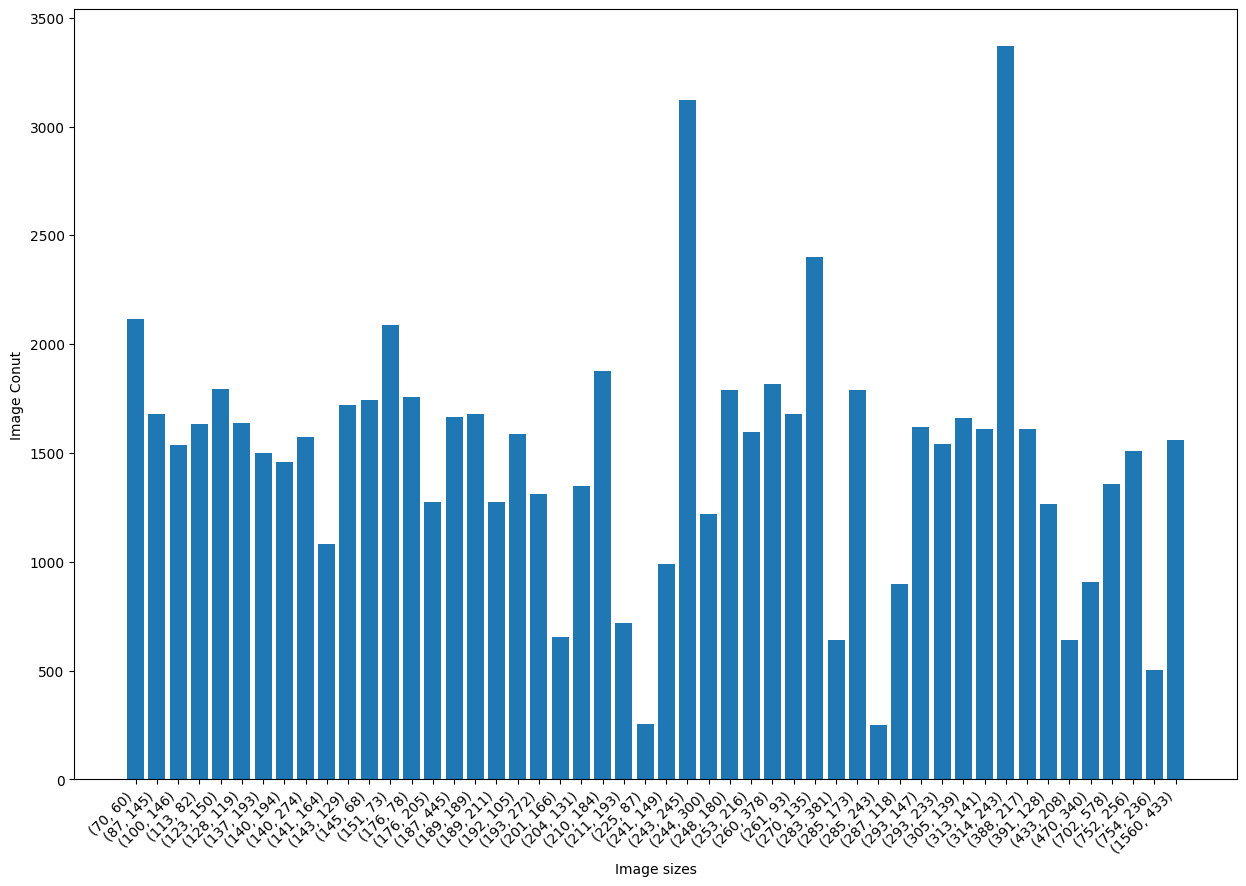

In [7]:
plt.rcParams["figure.figsize"] = (15,10)

x_vals = sorted([x for x in img_sizes.keys()])

fig, ax = plt.subplots()
ax.bar([str(x) for x in x_vals], img_sizes.values() )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("Image sizes")
ax.set_ylabel("Image Conut")
plt.show()

#### Aspect ratio count

In [8]:
accepted_ratios = {1:1, 2:1, 2.2:1, 5:4, 4:3, 3:2, 8:5, 5:3, 16:9, 17:9}
accepted_ratios_dic = {key/value:f"{key}:{value}" for key, value in accepted_ratios.items()}
def gcd(a, b):
    if b == 0: return a
    return gcd (b, a % b)

In [9]:
img_aspectratio = defaultdict(int)
aspect_ratio_to_img_size = defaultdict(set)
for img_addr in all_train_files:
    (width, height) = imagesize.get(img_addr)
    # _gcd = gcd(width, height)
    asr = width/height
    asr_div = min(list(accepted_ratios_dic.keys()), key=lambda x:abs(x-asr))
    aspectratio = accepted_ratios_dic[asr_div]
    aspect_ratio_to_img_size[accepted_ratios_dic[asr_div]].add((width, height))
    img_aspectratio[aspectratio] += 1




/tmp/ipykernel_16922/3244614732.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


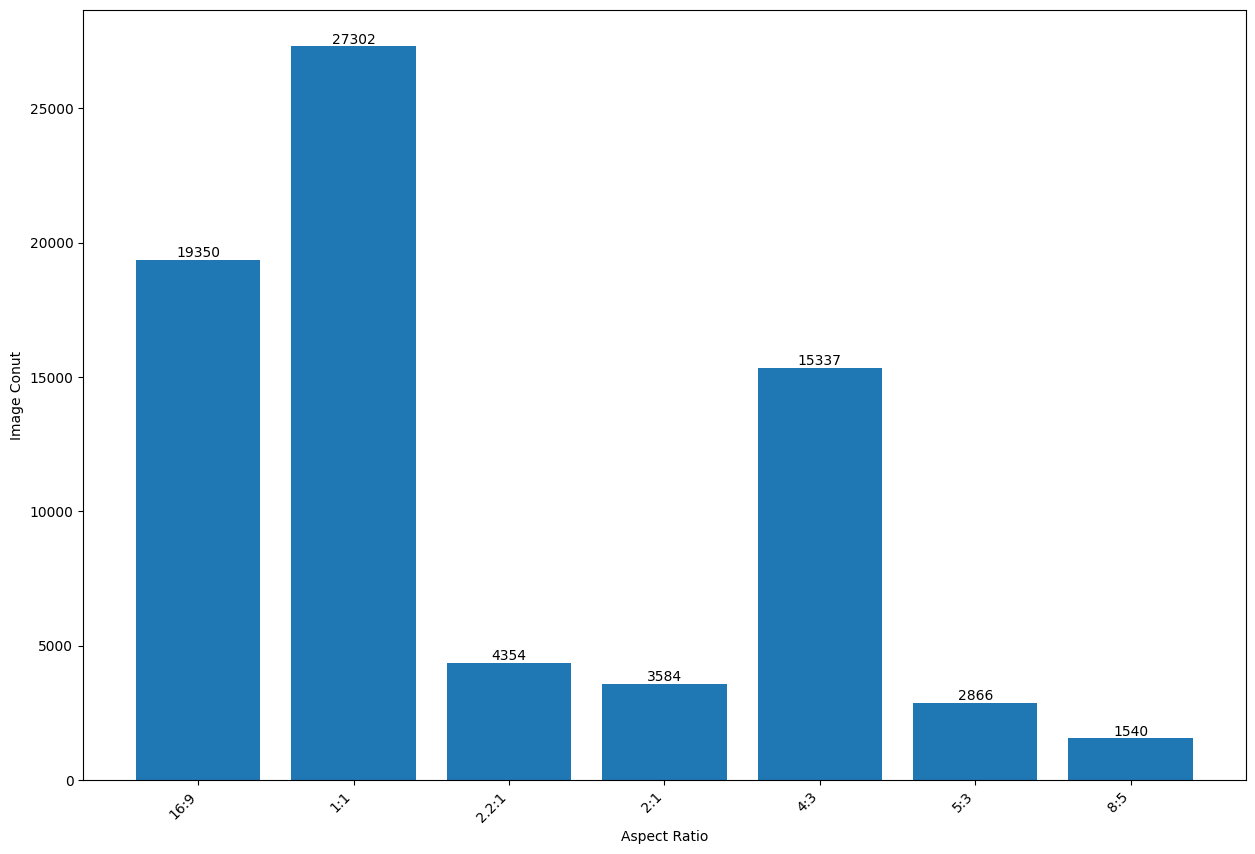

In [10]:

plt.rcParams["figure.figsize"] = (15,10)

x_vals = sorted([x for x in img_aspectratio.keys()])

fig, ax = plt.subplots()
ax.bar([str(x) for x in x_vals], img_aspectratio.values() )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("Aspect Ratio")
ax.set_ylabel("Image Conut")

for c in ax.containers:
    ax.bar_label(c,[str(x) for x in img_aspectratio.values()])
plt.show()

#### image sizes in each train subset

In [51]:
_trash, x_trash,y_trash = set(),[],[]
_no_trash, x_no_trash,y_no_trash = set(),[],[]
_doubt, x_doubt,y_doubt = set(),[],[]

for train_file in all_train_files:
    (width, height) = imagesize.get(train_file)
    if "train/trash" in train_file:
        _trash.add((width,height))
    elif "train/notrash" in train_file:
        _no_trash.add((width,height))
    elif "doubt" in train_file:
        _doubt.add((width,height))

for x,y in list(_trash):
    x_trash.append(x)
    y_trash.append(y) 


for x,y in list(_no_trash):
    x_no_trash.append(x)
    y_no_trash.append(y) 

for x,y in list(_doubt):
    x_doubt.append(x)
    y_doubt.append(y) 

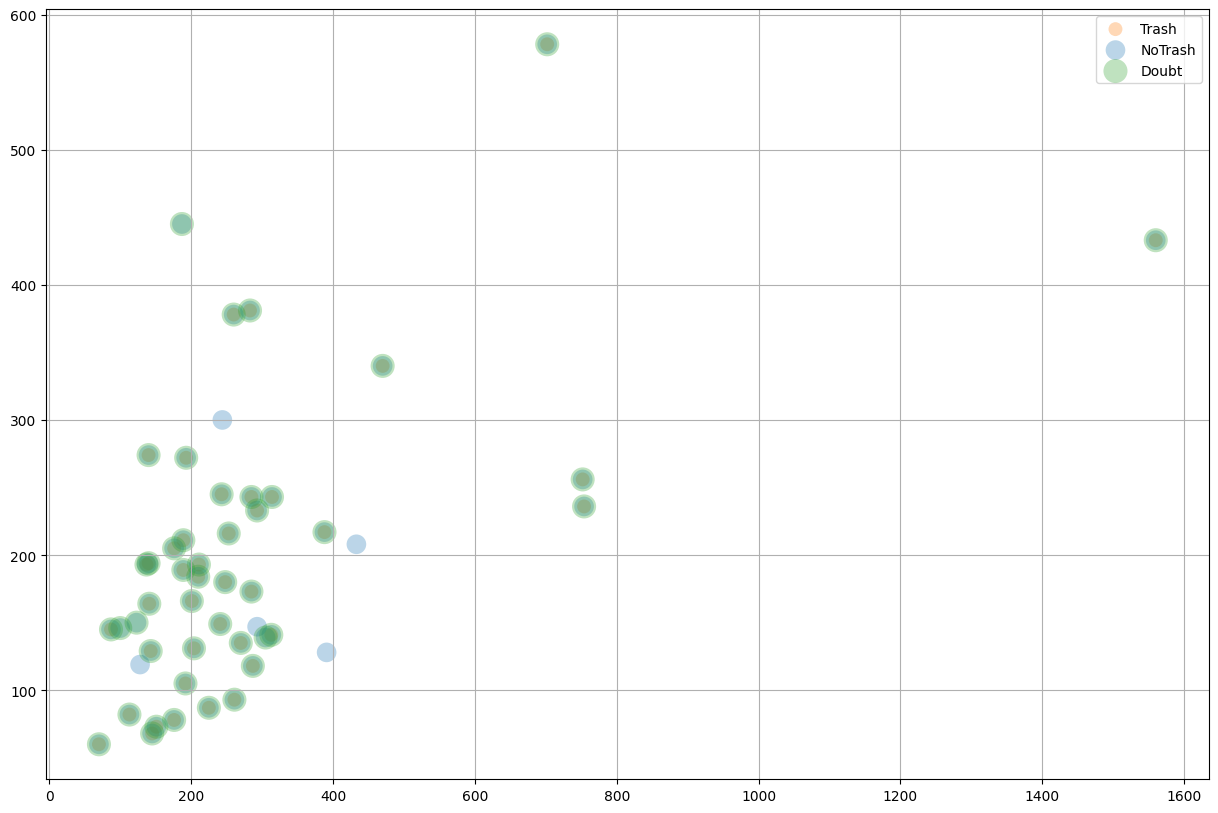

In [55]:
fig, ax = plt.subplots()
ax.scatter(list(x_trash), list(y_trash), c='tab:orange',s=100,alpha=0.3, edgecolors='none', label="Trash")
ax.scatter(list(x_no_trash), list(y_no_trash), c='tab:blue',s=200,alpha=0.3, edgecolors='none', label="NoTrash")
ax.scatter(list(x_doubt), list(y_doubt), c='tab:green',s=300,alpha=0.3, edgecolors='none', label="Doubt")

ax.legend()
ax.grid(True)
plt.show()

In [40]:
x_trash,y_trash = set(),set()
x_no_trash,y_no_trash = set(),set()
x_doubt,y_doubt = set(),set()

for train_file in all_test_files:
    (width, height) = imagesize.get(train_file)
    if "test/trash" in train_file:
        x_trash.add(width)
        y_trash.add(height)

    elif "test/notrash" in train_file:
        x_no_trash.add(width)
        y_no_trash.add(width)

    elif "doubt" in train_file:
        x_doubt.add(width)
        y_doubt.add(height)

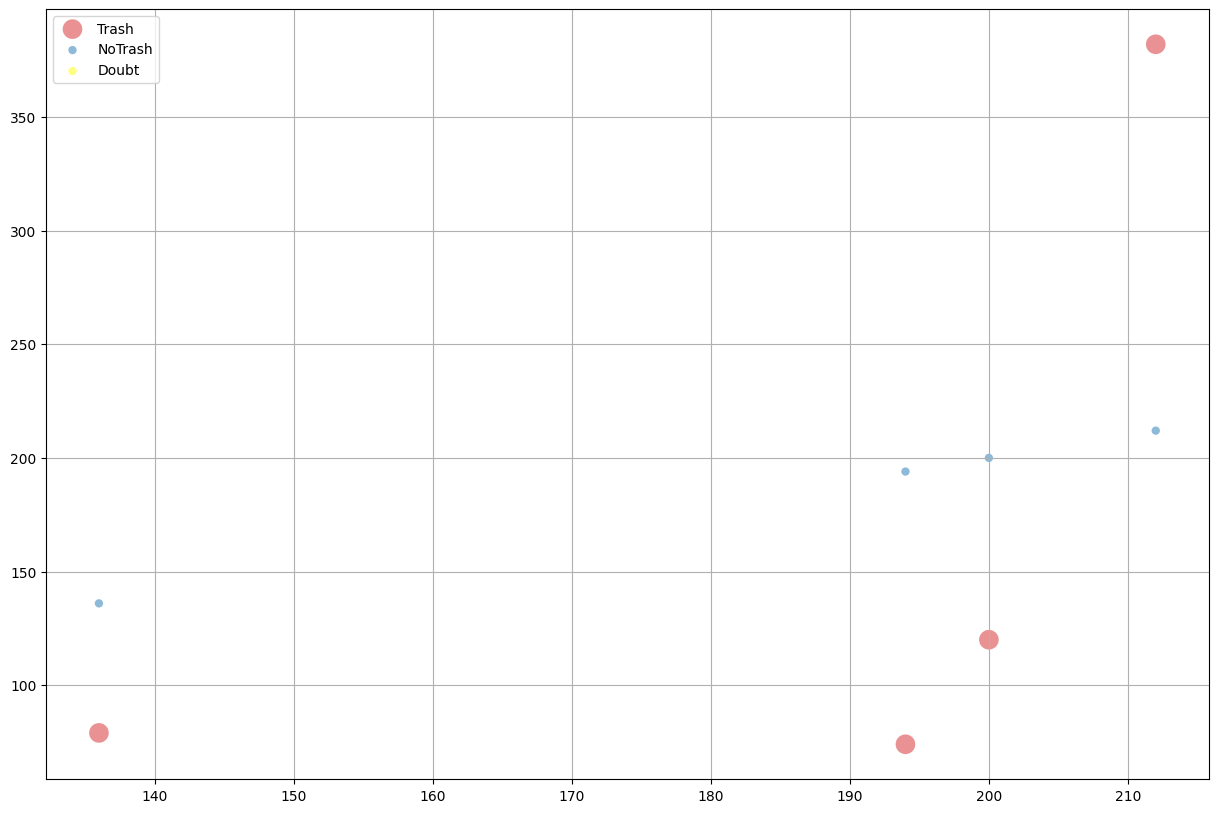

In [43]:
fig, ax = plt.subplots()
ax.grid(True)
ax.scatter(list(x_trash),list(y_trash), c='tab:red', s=200,alpha=0.5, edgecolors='none', label="Trash")
ax.scatter(list(x_no_trash), list(y_no_trash), c='tab:blue',lw=20,alpha=0.5, edgecolors='none', label="NoTrash")
ax.scatter(list(x_doubt), list(y_doubt), c='yellow',lw=20,alpha=0.5, edgecolors='none', label="Doubt")

ax.legend()

plt.show()

#### Show samples

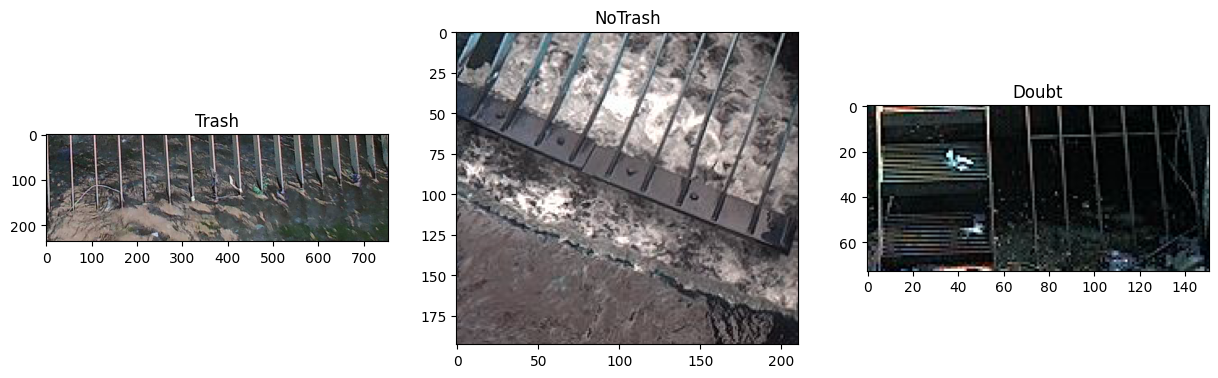

In [66]:
train_trash = all_train_files[random.randint(0,10048)]
train_notrash = all_train_files[random.randint(10048,10048+39937)]
train_doubt = all_train_files[random.randint(10048+39937,10048+39937+24348)] 

img_train_doubt = cv.imread(train_doubt)
img_train_notrash = cv.imread(train_notrash)
img_train_trash = cv.imread(train_trash)

fix, axes = plt.subplots(1,3)
axes[0].imshow(img_train_doubt)
axes[0].set_title("Trash")
axes[1].imshow(img_train_notrash)
axes[1].set_title("NoTrash")
axes[2].imshow(img_train_trash)
axes[2].set_title("Doubt")
plt.show()

#### Sizes inside Train
We train auto-encoder only with normal data 

In [2]:
train_files = glob.glob("../student_db/train/notrash/**/*.png",recursive=True) 
img_sizes = defaultdict(int)
for img_addr in train_files:
    (width, height) = imagesize.get(img_addr)
    img_sizes[(width, height)] += 1

defaultdict(int,
            {(293, 147): 909,
             (145, 68): 1188,
             (283, 381): 433,
             (151, 73): 542,
             (143, 129): 745,
             (241, 149): 855,
             (70, 60): 1434,
             (211, 193): 716,
             (752, 256): 995,
             (128, 119): 1358,
             (210, 184): 1596,
             (702, 578): 929,
             (260, 378): 1203,
             (261, 93): 380,
             (287, 118): 1231,
             (201, 166): 1397,
             (141, 164): 204,
             (470, 340): 1303,
             (123, 150): 1240,
             (313, 141): 140,
             (87, 145): 366,
             (140, 274): 599,
             (754, 236): 1568,
             (305, 139): 422,
             (100, 146): 1180,
             (189, 211): 344,
             (285, 173): 1169,
             (293, 233): 386,
             (204, 131): 1064,
             (314, 243): 62,
             (176, 78): 146,
             (140, 194): 419,
             (285,

#### Run t-SNE on train dataset

##### Create transformation

In [14]:
preprocess = T.Compose([
   T.Resize((64,64)),
   T.Grayscale(),

])
img = Image.open(all_train_files[0])
pp_img = preprocess(img)
pp_img.size


(64, 64)

In [45]:
def transformation(img_file):
    img = cv.imread(img_file)
    small_img = cv.resize(img, (128,128))
    img_gray = cv.cvtColor(small_img, cv.COLOR_BGR2GRAY)
    img_gray = np.reshape(img_gray, newshape=(1,16384))#
    return img_gray


results = Parallel(n_jobs=10)(delayed(transformation)(img_file) for img_file in all_train_files)
all_features = np.vstack(results)

In [46]:
tsne    = TSNE(n_components=2, perplexity=50, learning_rate=20)
tsne_2D = tsne.fit_transform(all_features)

[W] [23:30:50.945573] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


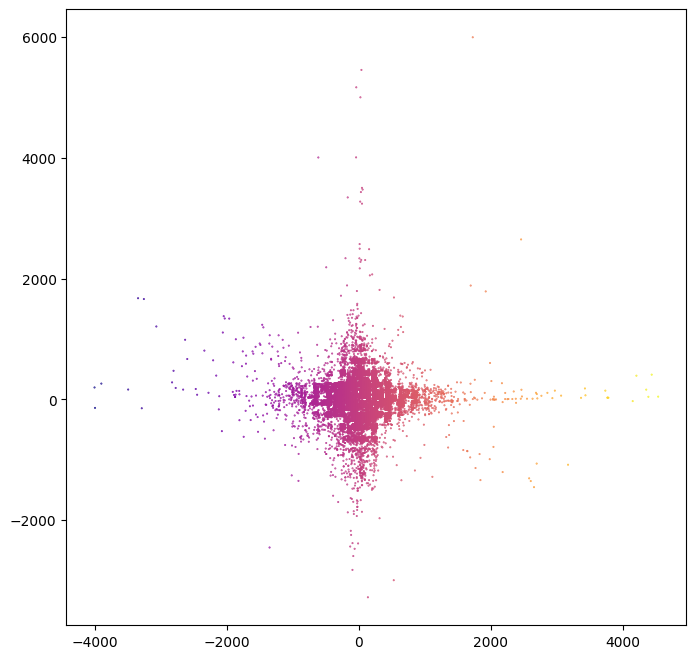

In [47]:
x, y = tsne_2D.T
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=0.2, c=x, cmap=plt.cm.plasma)
plt.show();

##### separate based on labels

In [48]:
labels = []
for train_file in all_train_files:
    (width, height) = imagesize.get(train_file)
    if "train/trash" in train_file:
        labels.append(0)
    elif "train/notrash" in train_file:
        labels.append(1)
    elif "doubt" in train_file:
        labels.append(2)
labels = np.array(labels)
labels

array([2, 2, 2, ..., 0, 0, 0])

/tmp/ipykernel_17575/830838935.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=0.2, c='red', cmap=plt.cm.plasma)
/tmp/ipykernel_17575/830838935.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=0.2, c="blue", cmap=plt.cm.plasma)
/tmp/ipykernel_17575/830838935.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=0.2, c="yellow", cmap=plt.cm.plasma)


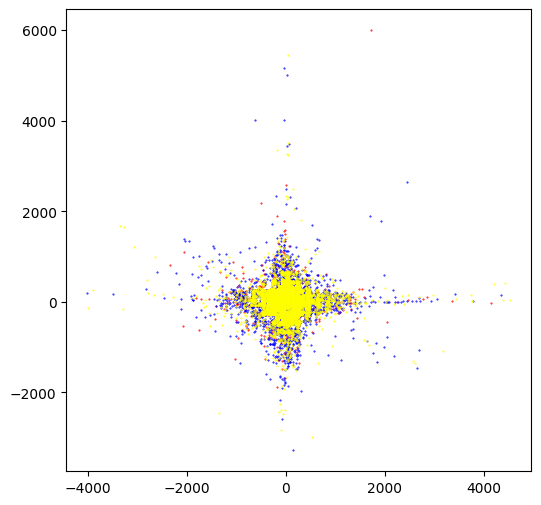

In [49]:
idx_trash = np.where(labels == 0)
idx_no_trash = np.where(labels == 1)
idx_doubt = np.where(labels == 2)

fig, ax = plt.subplots(figsize=(6, 6))
x, y = tsne_2D[idx_trash].T
ax.scatter(x, y, s=0.2, c='red', cmap=plt.cm.plasma)

x, y = tsne_2D[idx_no_trash].T
ax.scatter(x, y, s=0.2, c="blue", cmap=plt.cm.plasma)

x, y = tsne_2D[idx_doubt].T
ax.scatter(x, y, s=0.2, c="yellow", cmap=plt.cm.plasma)

plt.show();

In [37]:
tsne_2D[idx_trash].T.shape

(2, 10048)

In [56]:
from sklearn import datasets
# load dataset
data = datasets.fetch_openml(
    'Fashion-MNIST',
    version=1,
    return_X_y=True
)
# data returns a tuple (features, target)
features, target = data
features.shape

/root/AD-VAE/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)

In [61]:
all_features = np.empty(shape=(0,4096))
all_features

array([], shape=(0, 4096), dtype=float64)

In [68]:
np.vstack((all_features, np.random.rand(1,4096)))

array([[0.6037246 , 0.21871087, 0.4222542 , ..., 0.2443318 , 0.71960842,
        0.86460967]])

In [13]:
128*128

16384